https://www.nltk.org/book/ch05.html

Need to reduce more common words...

Need to prevent overfitting. Keeps predicting the same word for every possible input.

Replace mean squared with mean cube/fourth? Something to prioritize the largest errors.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
def stem(word):
    # sno = nltk.stem.SnowballStemmer('english')
    ps = WordNetLemmatizer()
    stem = ps.lemmatize(word)
    return stem

In [4]:
from nltk.corpus import brown
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
len(pd.Series(brown_news_tagged).unique())

15114

In [5]:
len(brown.words())

1161192

# Train Model

In [314]:
remove_punc = [word for word in brown_news_tagged if word[1] != "."]
text = [word[0].lower() for word in remove_punc][:5000]
# text = word_tokenize(open("text.txt", "r").readline())
len(text)

5000

In [315]:
pd.Series(text).value_counts()["called"]

2

In [316]:
corpus = pd.Series([word for word in text]).unique()
len(corpus)

1646

In [413]:
vecs = {}
dim = len(corpus)
for i in range(len(corpus)):
    #frequent word subsampling
    word_frequency = pd.Series(text).value_counts()[corpus[i]]/len(text)
    t = 0.02
    subsample_rate = (t/word_frequency)**0.5

    vecs[corpus[i]] = [subsample_rate if i == j else 0.0 for j in range(len(corpus))]
    # vecs[corpus[i]] = [1.0 if i == j else 0.0 for j in range(len(corpus))]
    #vecs[word] = np.random(dim)*2-np.ones(dim)

In [437]:
class Net(nn.Module):

    def __init__(self, in_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2*in_len, 128) #to embedding layer (the internal representation of the input word)
        self.fc2 = nn.Linear(128, in_len, bias=False) #to output (word before, word after)
    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    def embeddings(self, x):
        x = self.fc1(x)
        return x
    def loss_score(self, x, y):
        l = 0
        for i in range(len(x)):
            output = self(x[i])
            target = y[i]
            criterion_temp = nn.MSELoss()
            loss = criterion_temp(output, target)
            l += loss.item()/len(x)
        return l
net = Net(len(corpus))

params = list(net.parameters())

net.zero_grad()

def criterion(input, target):
    return sum((a-b)**3 for a,b in zip(input, target))/len(input)
nn.MSELoss()
# nn.CosineEmbeddingLoss()
# nn.MSELoss()
# nn.BCELoss
# nn.LocalResponseNorm


MSELoss()

In [438]:
x = []
y = []
individual_words = text
word_dict = vecs

scanning_window = 5
# for i in range(1,len(individual_words)-1):
#     x.append(torch.tensor(word_dict[individual_words[i]]))
#     y.append(torch.tensor(word_dict[individual_words[i-1]] + word_dict[individual_words[i+1]]))
x = np.zeros(len(individual_words)-2*scanning_window)
y = np.zeros(len(individual_words)-2*scanning_window)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)
len(x)

4990

In [439]:
# create your optimizer
losses = []
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [440]:
def generate_training_data(index, window = 10, data=individual_words):
    input_list = word_dict[data[index+window]]
    o0 = np.zeros(len(corpus))
    for i in range(-window, 0):
        if index + i >= 0:
            o0 += np.array(word_dict[data[index + i + window]]) * np.exp((i/window)**2 * -2)
    o1 = np.zeros(len(corpus))
    for i in range(1, window+1):
        if index + i < len(data):
            o1 += np.array(word_dict[data[index + i + window]]) * np.exp((i/window)**2 * -2)

    # o0 *= 1/((sum(x**2 for x in o0))**0.5)
    # o1 *= 1/((sum(x**2 for x in o1))**0.5)
    return torch.tensor([float(a) for a in input_list]), torch.tensor([float(a) for a in (list(o0) + list(o1))])

In [441]:
NUM_RUNS = 2
for run_num in range(NUM_RUNS):
    print("RUN", str(run_num+1)+"/"+str(NUM_RUNS), end=": ")
    for i in range(0,len(x_train),1):
        if i % (len(x_train)//20) == 0:
            print("•", end="")

        # input = x_train[i]
        # target = y_train[i]
        target, input = generate_training_data(i, window = scanning_window)
        if np.random.random() < 1 - max(target):
            continue

        optimizer.zero_grad()   # zero the gradient buffers
        output = net(input)
        loss = criterion(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()    # Does the update
    # plt.plot(losses)
    # plt.show()
    print()

RUN 1/2: •••••••••••••••••••••
RUN 2/2: •••••••••••••••••••••


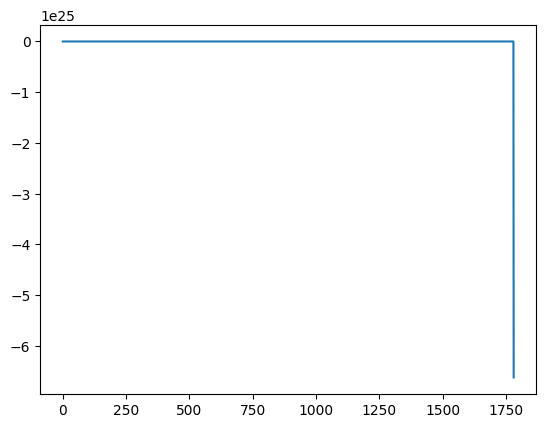

In [447]:
# N_test = 100
# print(net.loss_score(x_test, y_test))

plt.plot(losses)
plt.show()

# Test Model

In [443]:
def words_around(word):
    return net(word)

# l = words_around(torch.tensor(word_dict["live"]))
# # l1 = l[:len(l)//2]
# l1 = l[len(l)//2:]
# max_index = -1
# for i in range(len(l1)):
#     if l1[i] >= l1[max_index]:
#         max_index = i
# print(corpus[max_index])
# print(l1[max_index].item())



In [448]:
text_11_words = "there is person planning to do the the the the the the the the the"
gen = text_11_words.split(" ")
for i in range(5):
    input, output = generate_training_data(i, window=scanning_window, data=gen)
    o = net(output)
    o = list(o[:len(o)//2]) + list(0.1*torch.ones_like(o[len(o)//2:]))
    max_i = -1
    for i in range(len(o)):
        if o[i].item() > o[max_i].item():
            max_i = i
    max_i
    gen.insert(scanning_window+1, corpus[max_i])

gen

['there',
 'is',
 'person',
 'planning',
 'to',
 'do',
 '7.5',
 '7.5',
 '7.5',
 '7.5',
 '7.5',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the']

In [445]:
input = -1*torch.ones(2*len(corpus))
o = net(input)
o
max_i = -1
for i in range(len(o)):
    if o[i].item() > o[max_i].item():
        max_i = i
max_i
corpus[max_i]

'7.5'

In [446]:
generation = ["eats"]
for _ in range(5):
    l = words_around(torch.tensor([float(a) for a in word_dict[generation[-1]]] + [float(a) for a in np.zeros(dim)]))
    # l1 = l[len(l)//2:]
    l1 = l
    max_index = -1
    for i in range(len(l1)):
        if l1[i] >= l1[max_index]:
            max_index = i
    generation.append(corpus[max_index])

KeyError: 'eats'

In [ ]:
generation

['eats', 'the', 'cat', 'not', 'the', 'cat']

In [ ]:
pd.Series(text).value_counts()['mano']

KeyError: 'mano'

In [ ]:
def embeddings(word):
    return [v.item() for v in net.embeddings(torch.tensor(word_dict[word]))]
def cos_similarity(a, b):
    s = 0
    for i in range(len(a)):
        s += a[i] * b[i]
    s /= sum(e**2 for e in a)**0.5
    s /= sum(e**2 for e in b)**0.5
    return s
emb = [embeddings(word) for word in corpus]
ref = embeddings("noticed")

In [ ]:
min_i = -1
for i in range(len(corpus)):
    s = cos_similarity(emb[i], ref)
    if s != 0 and s <= cos_similarity(emb[min_i], ref):
        min_i = i
print(corpus[min_i])